In [ ]:
from __future__ import annotations
import contextlib
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.patches import Rectangle

from scipy.ndimage import gaussian_filter1d
from scipy.signal import resample_poly
from scipy.stats import rankdata
from scipy import stats

from statsmodels.stats.multitest import multipletests
from sklearn.covariance import LedoitWolf

from tqdm import tqdm
import joblib
from joblib import Parallel, delayed

from utils import load_pickle,extract_used_data,set_params
from utils.config import Params

In [13]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_cb = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_cb
        tqdm_object.close()


def get_data(entry_dir: str):
    path = Path(entry_dir)
    data_list = []
    for file in path.glob("*.pkl"):
        print(f"Loading {file}...")
        data = load_pickle(file)
        data = extract_used_data(data)
        data_list.append(data)
    return data_list


def _clamp_slice(s: int, e: int, T: int) -> tuple[int, int]:
    s = int(s); e = int(e)
    s = max(0, min(s, T))
    e = max(0, min(e, T))
    return s, e


def extract_ab_ba_one_session(
    data: dict,
    params: Params,
    ana_tt: list,
    ana_bt: list,
    *,
    extend_cm: float = 10.0,
    firing_key: str = "simple_firing",
):
    zones = data["zones"]
    zone1_idx = 1
    zone2_idx = 3

    denom = (params.space_unit * params.len_pos_average)
    s1 = int(np.floor((zones[zone1_idx][0] - extend_cm) / denom))
    e1 = int(np.ceil ((zones[zone1_idx][1] + extend_cm) / denom))
    s2 = int(np.floor((zones[zone2_idx][0] - extend_cm) / denom))
    e2 = int(np.ceil ((zones[zone2_idx][1] + extend_cm) / denom))

    data_AB_list = []
    data_BA_list = []

    for index in params.ana_index_grid(ana_tt, ana_bt):
        trial_type = params.tt[index[0]]
        fr = data[firing_key][index]
        if fr is None:
            continue

        # fr: (neurons, trials, position)
        fr = gaussian_filter1d(fr, sigma=params.gaussian_sigma, axis=2, mode="nearest", truncate=3.0)

        # downsample along position axis
        k = params.len_pos_average
        len_track = fr.shape[2]
        fr = fr[:, :, :(len_track - len_track % k)]
        fr = resample_poly(fr, up=1, down=k, axis=2)  # (neurons, trials, position_ds)

        T = fr.shape[2]
        s1c, e1c = _clamp_slice(s1, e1, T)
        s2c, e2c = _clamp_slice(s2, e2, T)
        if (e1c <= s1c) or (e2c <= s2c):
            continue

        seg1 = fr[:, :, s1c:e1c]
        seg2 = fr[:, :, s2c:e2c]
        fr_seg = np.concatenate([seg1, seg2], axis=2)  # (neurons, trials, L)

        if ("CAB" in trial_type) or ("ACB" in trial_type) or ("ABC" in trial_type):
            data_AB_list.append(fr_seg)
        elif ("CBA" in trial_type) or ("BCA" in trial_type) or ("BAC" in trial_type):
            data_BA_list.append(fr_seg)
        else:
            raise ValueError(f"Trial type not recognized: {trial_type}")

    if (len(data_AB_list) == 0) or (len(data_BA_list) == 0):
        return None, None

    data_AB = np.concatenate(data_AB_list, axis=1)  # (neurons, nAB, L)
    data_BA = np.concatenate(data_BA_list, axis=1)  # (neurons, nBA, L)
    return data_AB, data_BA


# =========================
# Fisher-vector + permutation + FDR
# =========================

def time_bin_mean(fr_seg, bin_size: int | None):
    if bin_size is None or bin_size <= 1:
        return fr_seg
    L = fr_seg.shape[2]
    L2 = (L // bin_size) * bin_size
    if L2 <= 0:
        return fr_seg
    x = fr_seg[:, :, :L2]
    x = x.reshape(x.shape[0], x.shape[1], L2 // bin_size, bin_size).mean(axis=3)
    return x


def _one_neuron_fisher_diag_perm(Xn_all, y, M, n_pos, n_neg, ridge=1e-6, eps=1e-12):
    """
    Xn_all: (n_trials, L)
    y: (n_trials,)
    M: (n_perm, n_trials) float32
    """
    X = Xn_all.astype(np.float64, copy=False)
    X2 = X * X

    total_sum = X.sum(axis=0)      # (L,)
    total_sum_sq = X2.sum(axis=0)  # (L,)

    Xpos = X[y == 1]
    Xneg = X[y == 0]
    if Xpos.shape[0] < 2 or Xneg.shape[0] < 2:
        return 0.0, 1.0

    mu_pos = Xpos.mean(axis=0)
    mu_neg = Xneg.mean(axis=0)
    delta = mu_pos - mu_neg

    var_pos = Xpos.var(axis=0, ddof=1)
    var_neg = Xneg.var(axis=0, ddof=1)
    sw = var_pos + var_neg + ridge
    stat_obs = float(np.sum((delta * delta) / (sw + eps)))

    # permutation：pos_sum = M @ X => (n_perm, L)
    pos_sum = M @ X
    pos_sum_sq = M @ X2

    neg_sum = total_sum[None, :] - pos_sum
    neg_sum_sq = total_sum_sq[None, :] - pos_sum_sq

    pos_mean = pos_sum / n_pos
    neg_mean = neg_sum / n_neg
    delta_p = pos_mean - neg_mean

    pos_var = (pos_sum_sq - (pos_sum * pos_sum) / n_pos) / max(n_pos - 1, 1)
    neg_var = (neg_sum_sq - (neg_sum * neg_sum) / n_neg) / max(n_neg - 1, 1)
    pos_var = np.maximum(pos_var, 0.0)
    neg_var = np.maximum(neg_var, 0.0)

    sw_p = pos_var + neg_var + ridge
    stat_null = np.sum((delta_p * delta_p) / (sw_p + eps), axis=1)

    p = (1.0 + np.sum(stat_null >= stat_obs)) / (len(stat_null) + 1.0)
    return stat_obs, p


def _fisher_vector_stat_lw(X0, X1, ridge=1e-6):
    mu0 = X0.mean(axis=0)
    mu1 = X1.mean(axis=0)
    delta = mu1 - mu0

    R0 = X0 - mu0
    R1 = X1 - mu1
    R = np.vstack([R0, R1])  # pooled residuals

    lw = LedoitWolf(assume_centered=True).fit(R)
    Sw = lw.covariance_.copy()
    L = Sw.shape[0]
    Sw.flat[::L + 1] += ridge

    z = np.linalg.solve(Sw, delta)
    return float(delta @ z)


def _one_neuron_fisher_lw_perm(Xn_all, y, perms, ridge=1e-6):
    X0 = Xn_all[y == 0]
    X1 = Xn_all[y == 1]
    if X0.shape[0] < 2 or X1.shape[0] < 2:
        return 0.0, 1.0

    obs = _fisher_vector_stat_lw(X0, X1, ridge=ridge)

    null = np.empty(len(perms), dtype=float)
    for i, yp in enumerate(perms):
        X0p = Xn_all[yp == 0]
        X1p = Xn_all[yp == 1]
        null[i] = _fisher_vector_stat_lw(X0p, X1p, ridge=ridge)

    p = (1.0 + np.sum(null >= obs)) / (len(null) + 1.0)
    return obs, p


def count_sig_neurons_fisher_vector(
    data_list,
    params: Params,
    ana_tt,
    ana_bt,
    *,
    extend_cm=10.0,
    n_perm=2000,
    alpha=0.05,
    seed=0,
    cov="diag",        # "diag" or "lw"
    ridge=1e-6,
    time_bin=5,        # 5~10
    n_jobs=8,
    backend="threading",
):
    rng = np.random.RandomState(seed)
    out = []

    for si, data in enumerate(tqdm(data_list, desc="sessions", dynamic_ncols=True)):
        data_AB, data_BA = extract_ab_ba_one_session(data, params, ana_tt, ana_bt, extend_cm=extend_cm)
        if data_AB is None:
            out.append({"session": si, "n_sig": 0, "n_neuron": 0, "p": None, "q": None})
            continue

        data_AB = time_bin_mean(data_AB, time_bin)
        data_BA = time_bin_mean(data_BA, time_bin)

        n_neuron = data_AB.shape[0]
        nAB = data_AB.shape[1]
        nBA = data_BA.shape[1]

        y = np.concatenate([np.zeros(nAB, int), np.ones(nBA, int)])
        n_trials = y.size
        n_pos = int(y.sum())
        n_neg = int(n_trials - n_pos)
        if n_pos < 2 or n_neg < 2:
            out.append({"session": si, "n_sig": 0, "n_neuron": n_neuron, "p": None, "q": None})
            continue

        perm_idx = np.array([rng.permutation(n_trials) for _ in range(n_perm)], dtype=np.int32)
        y_perm = y[perm_idx]
        M = (y_perm == 1).astype(np.float32)

        perms = [y_perm[i, :] for i in range(n_perm)]

        def _task(neuron_id: int):
            Xn_all = np.vstack([data_AB[neuron_id, :, :], data_BA[neuron_id, :, :]])  # (n_trials, L)
            if cov == "diag":
                return _one_neuron_fisher_diag_perm(Xn_all, y, M, n_pos, n_neg, ridge=ridge)
            elif cov == "lw":
                return _one_neuron_fisher_lw_perm(Xn_all, y, perms, ridge=ridge)
            else:
                raise ValueError("cov must be 'diag' or 'lw'")

        with tqdm_joblib(tqdm(total=n_neuron, desc=f"session {si} neurons (fisher-{cov})",
                              leave=False, dynamic_ncols=True)):
            results = Parallel(n_jobs=n_jobs, backend=backend)(
                delayed(_task)(n) for n in range(n_neuron)
            )

        stat_obs = np.array([r[0] for r in results], dtype=float)
        pvals = np.array([r[1] for r in results], dtype=float)

        rej, qvals, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
        out.append({
            "session": si,
            "n_sig": int(rej.sum()),
            "n_neuron": n_neuron,
            "p": pvals,
            "q": qvals,
            "stat": stat_obs,
            "sig_mask": rej,
            "cov": cov,
            "time_bin": time_bin,
        })

    return out


# =========================
# example usage
# =========================
# data_list = get_data("your_entry_dir")
# params = set_params(...)
# ana_tt = ["*"]; ana_bt = ["correct"]  # 示例
#
# Fisher-vector lw
# res_flw = count_sig_neurons_fisher_vector_fast(
#     data_list, params, ana_tt, ana_bt,
#     cov="lw", time_bin=8,
#     n_perm=1000, alpha=0.05,
#     n_jobs=10, backend="threading"
# )


In [15]:
entry_dir = "../../data/first_to_pat/"

data_list = get_data(entry_dir)

params = set_params(tt_preset="basic",
                    bt_preset="basic",
                    len_pos_average=10,
                    gaussian_sigma=25)


Loading ../../data/first_to_pat/RB05-PFCsep.pkl...
Loading ../../data/first_to_pat/RB07-PFCsep.pkl...
Loading ../../data/first_to_pat/RB04-PFCsep.pkl...


In [4]:
# res_auc = count_sig_neurons_auc_dprime(
#     data_list, params, ana_tt=["*"], ana_bt=["*"],
#     test_stat="auc", reduce="mean",
#     n_perm=5000, alpha=0.05,
#     n_jobs=10, backend="threading"
# )

In [5]:
res_flw1 = count_sig_neurons_fisher_vector(
    data_list, params, ana_tt=["couple*"], ana_bt=["*"],
    cov="lw", time_bin=10, extend_cm=20,
    n_perm=1000, alpha=0.05,
    n_jobs=10, backend="threading"
)


sessions:   0%|          | 0/2 [00:00<?, ?it/s]

session 0 neurons (fisher-lw):   0%|          | 0/217 [00:00<?, ?it/s]

session 1 neurons (fisher-lw):   0%|          | 0/377 [00:00<?, ?it/s]

In [6]:
res_flw2 = count_sig_neurons_fisher_vector(
    data_list, params, ana_tt=["position*"], ana_bt=["*"],
    cov="lw", time_bin=10, extend_cm=20,
    n_perm=1000, alpha=0.05,
    n_jobs=10, backend="threading"
)

sessions:   0%|          | 0/2 [00:00<?, ?it/s]

session 0 neurons (fisher-lw):   0%|          | 0/217 [00:00<?, ?it/s]

session 1 neurons (fisher-lw):   0%|          | 0/377 [00:00<?, ?it/s]

In [7]:
for r in res_flw1:
    print(r["session"], r["n_sig"], "/", r["n_neuron"])

0 5 / 217
1 0 / 377


In [8]:
for r in res_flw2:
    print(r["session"], r["n_sig"], "/", r["n_neuron"])

0 23 / 217
1 16 / 377


In [9]:

def _p_to_star(p: float) -> str:
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return "n.s."

def paired_rate_ttest_scatter(
    res1, res2,
    *,
    label1="flw1",
    label2="flw2",
    show_identity=True,
):
    """
    res1/res2: list[dict], each dict has keys: "session","n_sig","n_neuron"
    默认按 res1 的顺序配对（不排序），如果 res2 缺某个 session 会跳过。
    """

    # build session -> record map for res2
    map2 = {int(r["session"]): r for r in res2}

    sessions = []
    x1 = []
    x2 = []

    for r1 in res1:
        s = int(r1["session"])
        if s not in map2:
            continue
        r2 = map2[s]

        n1 = float(r1["n_neuron"]); n2 = float(r2["n_neuron"])
        if n1 <= 0 or n2 <= 0:
            continue

        rate1 = float(r1["n_sig"]) / n1
        rate2 = float(r2["n_sig"]) / n2

        if np.isfinite(rate1) and np.isfinite(rate2):
            sessions.append(s)
            x1.append(rate1)
            x2.append(rate2)

    x1 = np.asarray(x1, float)
    x2 = np.asarray(x2, float)

    if len(x1) < 2:
        raise ValueError("配对样本数 < 2，无法做 paired t-test。")

    # paired t-test: H0 mean(x2-x1)=0 :contentReference[oaicite:1]{index=1}
    tstat, pval = stats.ttest_rel(x2, x1, alternative="two-sided")

    diff = x2 - x1
    n = len(diff)
    mean_diff = diff.mean()
    sd_diff = diff.std(ddof=1)
    dz = mean_diff / sd_diff if sd_diff > 0 else np.nan  # paired Cohen's dz

    # 95% CI for mean difference
    sem = sd_diff / np.sqrt(n)
    tcrit = stats.t.ppf(0.975, df=n - 1)
    ci_lo, ci_hi = mean_diff - tcrit * sem, mean_diff + tcrit * sem

    # ---- plot: only the "right" panel (paired scatter) ----
    fig = plt.figure(figsize=(5, 4.5))
    ax = fig.gca()

    ax.scatter(x1, x2, s=50, alpha=0.9)

    # identity line
    mn = np.nanmin([x1.min(), x2.min()])
    mx = np.nanmax([x1.max(), x2.max()])
    pad = 0.08 * (mx - mn + 1e-12)
    lo, hi = mn - pad, mx + pad

    if show_identity:
        ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1.2, color="k", alpha=0.7)

    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)

    ax.set_xlabel(f"{label1}", fontsize=12)
    ax.set_ylabel(f"{label2}", fontsize=12)
    ax.set_title("Paired comparison (rate)", fontsize=13)

    # annotation text (on plot) :contentReference[oaicite:2]{index=2}
    star = _p_to_star(pval)
    txt = (
        f"paired t-test: {star}\n"
        f"n={n}, p={pval:.3g}\n"
    )
    ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left", fontsize=12, color="k")

    # cosmetics
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.xaxis.set_ticks_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.tick_params(axis="both", which="major", labelsize=12)

    plt.tight_layout()
    plt.show()



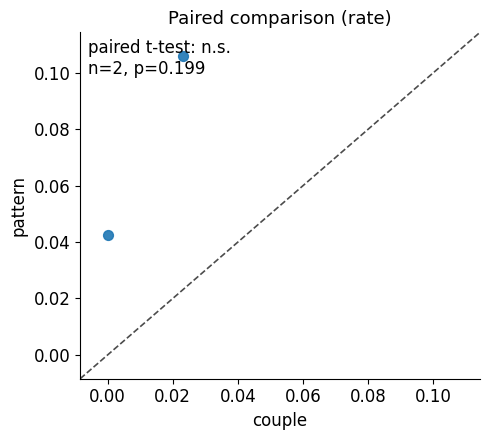

In [10]:
out = paired_rate_ttest_scatter(res_flw1, res_flw2, label1="couple", label2="pattern")